#### testing MSE-based instability proxy and its relationship with MCS
- check if instability (thetae_850 - thetae_500) can protrait where MCS are located 

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def coordinates_processors(data):
    """
    converting longitude/latitude into lon/lat
    data: xarray.dataset coordinated horizontally in lat/lon
    """

    coord_names = []
    for coord_name in data.coords:
        coord_names.append(coord_name)

    if (set(coord_names) & set(['lon','lat'])): # if coordinates set this way...

        data2 = data.rename({'lat': 'latitude'})
        data2 = data2.rename({'lon': 'longitude'})

    else:
        data2 = data

    # check if lon from -180
    if data2.longitude[0] != 0: # -180 to 180

        lon_reset = data2.longitude
        lon_reset = lon_reset.where(lon_reset > 0, 360+lon_reset) # converting lon as 0 to 359.75
        data2.coords['longitude'] = lon_reset # converting lon as -180 to 180
        data2= data2.sortby('longitude')

    # check if latitutde is decreasing
    if (data2.latitude[1] - data2.latitude[0]) < 0:
        data2 = data2.isel(latitude=slice(None, None, -1)) # flipping latitude accoordingly

    return data2

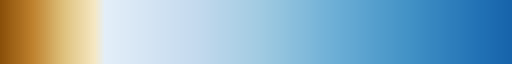

In [4]:
colors1 = plt.cm.BrBG(np.linspace(0.1, 0.4, 10))
colors2 = plt.cm.Blues(np.linspace(0.1, 0.8, 40))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [6]:
%%time
# get hourly animation instead of 6-hourly from the RGMA PFIDs 

year_sel = 2019

for month_sel in [5,6,7]:

    era5_dir = Path('/neelin2020/ERA-5_mse/{}'.format(year_sel))
    data_mse = xr.open_dataset(era5_dir / 'ERA-5.mse.{}.{}.nc'.format(year_sel,str(month_sel).zfill(2)))
    dmse_sfc500 = data_mse.mse_850 - data_mse.mse_sat_500 # currently 850 vs sat,500

    mask_dir = Path('/neelin2020/mcs_flextrkr/{}'.format(year_sel))
    # load origional front masks
    ft_dir = Path('/neelin2020/RGMA_feature_mask/data_product/{}/Front'.format(year_sel))
    files = sorted(list(ft_dir.glob('Front_cold_ERA5feature_mask_{}_{}_6hrly.compress.nc'.format(year_sel, str(month_sel).zfill(2)))))
    data_front_c = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
    data_front_c = coordinates_processors(data_front_c)
    files = sorted(list(ft_dir.glob('Front_warm_ERA5feature_mask_{}_{}_6hrly.compress.nc'.format(year_sel, str(month_sel).zfill(2)))))
    data_front_w = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
    data_front_w = coordinates_processors(data_front_w)
    files = sorted(list(ft_dir.glob('Front_stat_ERA5feature_mask_{}_{}_6hrly.compress.nc'.format(year_sel, str(month_sel).zfill(2)))))
    data_front_s = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
    data_front_s = coordinates_processors(data_front_s)

    for n,time_sel in enumerate(data_mse.time.values):
        #print('Time = {}'.format(time_sel))
        year = str(time_sel)[:4]
        mon = str(time_sel)[5:7]
        day = str(time_sel)[8:10]
        hour = str(time_sel)[11:13]

        dmse_masked = dmse_sfc500.sel(time=time_sel).sel(latitude=slice(39.34,29.34),longitude=slice(267.66,277.66))
        dmse_masked = dmse_masked.reindex(lat=reversed(dmse_masked))
        dmse_masked = dmse_masked.where(dmse_masked >= -5)

        try:
                ds = xr.open_dataset(mask_dir / 'mcstrack_{}{}{}_{}30.nc'.format(year,mon,day,hour)).isel(time=0)
                ds['lon'] = ds.lon.where(ds.lon > 0, 360 + ds.lon)
                ds = ds.sortby('lon').sel(lat=slice(29.34,39.34),lon=slice(267.66,277.66))
                precip = ds.precipitation
                precip_mask = precip.where(precip > 0)
                mcs_mask = ds.cloudtracknumber_nomergesplit
                mcs_mask = mcs_mask.where(mcs_mask > 0, 0)
                mcs_mask = mcs_mask.where(mcs_mask == 0, 1) 
                mcs_mask = mcs_mask.where(mcs_mask == 1) # 1 or NaN

                front_c = data_front_c.sel(time=time_sel, method='nearest').sel(latitude=slice(29.34,39.34),longitude=slice(267.66,277.66))
                front_c = front_c.where(front_c == 1)
                front_w = data_front_w.sel(time=time_sel, method='nearest').sel(latitude=slice(29.34,39.34),longitude=slice(267.66,277.66))
                front_w = front_w.where(front_w == 1)
                front_s = data_front_s.sel(time=time_sel, method='nearest').sel(latitude=slice(29.34,39.34),longitude=slice(267.66,277.66))
                front_s = front_s.where(front_s == 1)

                # plot figure
                fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
                ax.coastlines(resolution='50m', color='k',linewidth=0.5)
                ax.add_feature(cfeat.LAND,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3) 
                ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)
                ax.add_feature(cfeat.STATES,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)

                cp = ax.pcolormesh(dmse_masked.longitude, dmse_masked.latitude, dmse_masked, vmin=-5,vmax=10, zorder=1
                                , cmap=mixedmap, transform=ccrs.PlateCarree())
                cbar = plt.colorbar(cp, ax=ax, shrink=0.6, pad=0.02, extend='max')
                cp.cmap.set_under('w')
                cbar.ax.tick_params(labelsize=9) 
                cbar.set_label('MSE$_{sfc}$ - MSE$_{500,sat}$ (KJ/kg)',fontsize=9)

                # add precip
                ax.contour(precip_mask.lon, precip_mask.lat, precip_mask, levels=[0.5,2,4,6,8], zorder=2, cmap='jet', alpha=0.3
                        , transform=ccrs.PlateCarree())
                # add MCS features on top of the MSE map
                ax.contour(mcs_mask.lon, mcs_mask.lat, mcs_mask.fillna(0), levels=[0.9,1.1], zorder=3, colors=['m'], alpha=0.7
                        , transform=ccrs.PlateCarree())
                # add fronts
                ax.pcolormesh(front_c.longitude, front_c.latitude, front_c, cmap=ListedColormap(['navy']), 
                                transform=ccrs.PlateCarree(), zorder=3) # cold front
                ax.pcolormesh(front_w.longitude, front_w.latitude, front_w, cmap=ListedColormap(['r']), 
                                transform=ccrs.PlateCarree(), zorder=3) # cold front
                ax.pcolormesh(front_s.longitude, front_s.latitude, front_s, cmap=ListedColormap(['chocolate']), 
                                transform=ccrs.PlateCarree(), zorder=3) # cold front           

                gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                linewidth=1, color='gray', alpha=0.4, linestyle=':')
                gl.xlabels_top = False
                gl.ylabels_right = False
                gl.xformatter = LONGITUDE_FORMATTER
                gl.yformatter = LATITUDE_FORMATTER
                gl.xlabel_style = {'size':9}
                gl.ylabel_style = {'size':9}

                ax.set_title('MSE instability (MSE$_{sfc}$-MSE$_{sat,500}$) ' + 'MCS (magenta) \n {}.{}.{}.{}'.format(year,mon,day,hour)
                ,fontsize=7)

                out_dir = Path('/scratch/wmtsai/temp_mcs/fig_MCS_MSEinstability/SEUS_MCS_FT_850/{}'.format(mon))
                os.system('mkdir -p {}'.format(out_dir))
                fig.savefig(out_dir / 'SEUS_MCS_Fronts_MSEsfc500instability_{}.png'.format(str(n).zfill(3)),
                       dpi=300, bbox_inches='tight', transparent=False)
                plt.close()
        except:
                print('missing mcsflextrkr: {}'.format(str(time_sel)))

missing mcsflextrkr: 2019-07-05T21:00:00.000000000
missing mcsflextrkr: 2019-07-05T22:00:00.000000000
CPU times: user 28min 40s, sys: 24min 13s, total: 52min 54s
Wall time: 32min 43s


In [ ]:
### 1. buoyancy-precip 1-D: all grids, MCS grids, non-MCS grids 

### get B-P data of all grids ####
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/buoy_precip_1D_multiregions/SEUS')
files = sorted(list(out_dir.glob('buoy_precipitation_SEUS*')))
for n,file in enumerate(files):
    data_all = xr.open_dataset(file)
    if n == 0:
        samples = data_all.samples
        prec_sum = data_all.prec_gpm_sum
    else:
        samples += data_all.samples
        prec_sum += data_all.prec_gpm_sum
    
cond_prec = prec_sum/samples
# masking out under-sampled values
cond_prec = cond_prec.where(samples > 100)

# ###### plotting #######
fig,(ax,ax1) = plt.subplots(1,2,figsize=(7,3)) 

ax2 = ax.twinx() # for PDF
for gtype,color in zip(['non_MCS'], ['k']):

    ax.plot(data_all.BL_bins, cond_prec.sel(grid_type=gtype), 'o', color=color, markeredgecolor='none', ls='None', ms=5, 
        alpha=0.5)
    ax2.plot(data_all.BL_bins, samples.sel(grid_type=gtype)/samples.sel(grid_type=gtype).sum(), '-', color=color, alpha=0.6)
    ax2.set_ylim([0,0.05])
    ax2.tick_params(labelsize=9)

for gtype,color in zip(['MCS'], ['r']):

    ax.plot(data_all.BL_bins, cond_prec.sel(grid_type=gtype), '^', color=color, markeredgecolor='none', ls='None', ms=6, 
        alpha=0.5)
    ax2.plot(data_all.BL_bins, samples.sel(grid_type=gtype)/samples.sel(grid_type=gtype).sum(), '-', color=color, alpha=0.6)
    ax2.set_ylim([0,0.05])
    ax2.tick_params(labelsize=9)

ax.set_ylabel('Precipitation rate (mm hr$^{-1}$)',fontsize=9)
ax.set_xlabel('Buoyancy measure, B$_{L}$ (K)',fontsize=9)
ax.tick_params(labelsize=9)
ax.set_ylim([0,10])
ax.set_xlim([-20,5])
ax.grid(lw=0.2,ls=':',color='grey')
ax.legend(['Non-MCS','MCS'],
           bbox_to_anchor=(0.00, 0.35, 0.5, 0.5),fontsize=10, frameon=False)
ax.text(x=-18, y=8.7, s='Southeastern U.S.', fontsize=10, fontweight='bold',
        bbox=dict(facecolor='w', edgecolor='none', pad=2.5, lw=0.5))
ax.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)

# ###### plotting b. BL contribution from MCS#######
fraction_mcs = samples.sel(grid_type='MCS') /samples.sum('grid_type')
fraction_mcs = fraction_mcs.where(samples.sum('grid_type') >200)

ax1.plot(fraction_mcs.BL_bins, 100*fraction_mcs, 'o', color='k', markeredgecolor='none', ls='None', ms=5, 
        alpha=0.8)
    
ax1.set_ylabel('MCS contribution (%)',fontsize=9)
ax1.set_xlabel('Buoyancy measure, B$_{L}$ (K)',fontsize=9)
ax1.tick_params(labelsize=9)
ax1.set_ylim([0,100])
ax1.set_xlim([-20,5])
ax1.grid(lw=0.2,ls=':',color='grey')
ax1.spines[['right', 'top']].set_visible(False)

#add a inset of SEUS geolocation map 
axins = inset_axes(ax1, width="65%", height="65%", loc='lower left',
                   bbox_to_anchor=(0.05, 0.3, 0.8, 1),
                   bbox_transform=ax1.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes,
                   axes_kwargs=dict(projection=ccrs.PlateCarree()))
axins.stock_img()
axins.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
axins.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
axins.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
inset_extent = [-82, -90, 28.5, 36.5]
axins.set_extent(inset_extent)

plt.tight_layout()
#plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/ARM_BuoyPrec_SEUS.pdf',
       bbox_inches='tight', transparent=False)

In [ ]:
data_all